In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
import scipy.integrate as integ

from astropy.modeling.models import BlackBody
from astropy.modeling.blackbody import blackbody_lambda
from astropy.modeling.blackbody import blackbody_nu

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

# Project 3: "La Palma": Anatomy of a sunspot

#### Candidate numbers: 15908 and 15904

What are sunspots? This is a question scientiests still ask, and phenomenons we try to learn more about. 
We want to use spectral observations of the Sun, taken at the Roque de Los Muchachos Observatory with the Swedish 1-m Solar Telescope (SST) at La Palma, in order to learn more about these dark spots appearing on the Sun's photosphere. Among other things, we want to determine the parameters of the atmosphere, investigate brightness temperature, velocities, and magnetic fields, in order to tell us more about the sunspot, how it compares with the solar granulation around, and its properties. By use of these observations, we can create plots in order to better understand their behaviour and possible connections between the different properties. From the observations, we get values for the intensity [W / (Hz m2 sr)], Stokes V (circular polarisation) [W / (Hz m2 sr)] and the wavelength [nm]. There are 13 wavelengths, roughly covering the FeI 617 nm line profile. Before we get into the technicalities, we can plot the intensities for one spectral line, the Fe I line at 617.334 nm with an effective Landé factor $\overline{g}$ of 2.499 read from the received observations, and by use of constants collected from $\verb|astropy|$, in order to get a better understanding of the looks of a sunspot. 

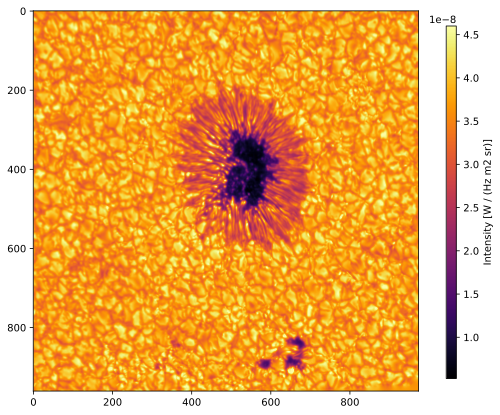

In [3]:
# Define variables:
e = constants.e
c = constants.c
m_e = constants.m_e
k_B = constants.k_B
h = constants.h
g_ = 2.499                 #effective Landé factor


# Read observations from data set:
data = QTable.read('SST_sunspot_617_2020.08.07.fits')
Stokes_V = data["stokes_v"]
intensity = data["intensity"]
lam = data["wavelength"]   #observed Doppler-shifted wavelength

fig, ax = plt.subplots(figsize=(7,7))
im_I = ax.imshow(data['intensity'][0].value, vmax=4.6e-8, cmap='inferno');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_I, cax=cbar_ax)
cbar.set_label("Intensity [W / (Hz m2 sr)]",size=10)

In the plot presented above we see the observed intensity from a sunspot, consisting of an umbra and a penumbra. The darkest area in the middle where the intensity is low is called the umbra, the surrounded slightly ligther area is called the penumbra, the yellow dots covering the larger area where the intensity is higher is called the granulation, and the three dark spots in the bottom right corner of the plot is called pores. We observe that they also have a lower intensity in comparison with the surroundings, but are lacking their own penumbra. These different areas can also be visualized in another spectral line plot, where the normalized intensity of a certain (x,y) point is plottet as a function of wavelength.

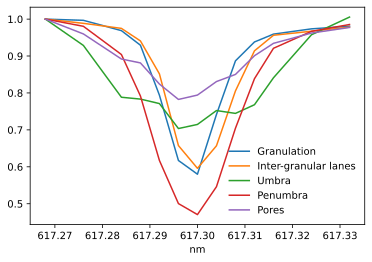

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(lam, intensity[:, 200, 200]/intensity[0, 200,200], label='Granulation')
ax.plot(lam, intensity[:, 800, 200]/intensity[0, 800, 200], label='Inter-granular lanes')
ax.plot(lam, intensity[:, 400, 550]/intensity[0, 400, 550], label='Umbra')
ax.plot(lam, intensity[:, 400, 450]/intensity[0, 400, 450], label='Penumbra')
ax.plot(lam, intensity[:, 900, 590]/intensity[0, 900, 590], label='Pores')
ax.legend();

The results from this plot, showing the spectral line of iron, indicates that there is less iron in the umbra and the pores, and that there is more iron in the penumbra. We also observe that the broadening of the lines representing the pores and the umbra is greater. This is an interesting observation, which may have a connection with other properties of the sunspot like the magnetic field.


These sunspots can be large, and exactly this sunspot can be compared with the size of the earth by looking at the pixels in the plot, where one pixel corresponds to 42.46 km on the solar surface. If we assume that the sunspot is circular and approximate it to the size $350 \times 350$ pixels, that the area of the earth is approximately $128 \cdot 10^6$ km$^2$ and that the earth radius is 12742 km, we can find the size of the sunspot compared to the Earth. 

The earth is 73.79 percent the size of the sunspot


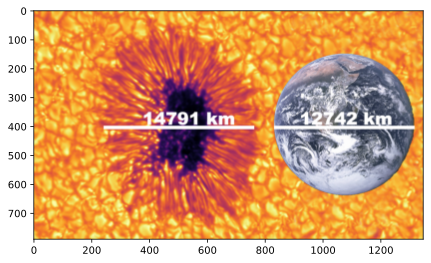

In [5]:
# Sunspot size compared to Earth:
area_sunspot = np.pi * (175*42.46)**2
area_earth = 128000000
percent = (area_earth*100) / area_sunspot
print("The earth is %.2f percent the size of the sunspot" %percent)

from PIL import Image
sunspot_earth = Image.open("sunspot_earth2.png")
fig, ax = plt.subplots(figsize=(7,7))
im_scale = ax.imshow(sunspot_earth);

In the image presented above, we observe that the Earth is approximately 73.79 % the size of the sunspot, which is quite big. Now that we have a certain impression of the size and looks of this sunspot, we want to learn more about its properties. 


First, we want to find the surface temperature $T_b$ and the velocities, in order to investigate the dynamics of the solar granulation and the sunspot, and how they are moving in relation to us. If we look at the frequency related Planck function

\begin{align}
B_{\nu}(T) = \frac{2 h \nu^3}{c^2} \frac{1}{e^{\frac{h \nu}{k_B T} - 1}},
\end{align}

and assume that the radiation is of a black body, the brightness temperature is the temperature which needs to be implemented into this expression, in order to be able to say

\begin{align}
B_{\nu}(T_b) = I_{\nu}^{\text{obs}},
\end{align}

where $I_{\nu}^{\text{obs}}$ is the observed intensity. So we can also assume that $I_{\nu} \propto B_{\nu}$, and that $T_b$ is the same for all frequencies. This means that $T_b$ from continuum intensity is more likely to be close to the effective temperature of the star, which indicates that we can use $I_0$ and $\lambda_0$ when calculating $T_b$.
We want to use $\lambda_0 = 617.300$ nm as the rest wavelength. 

When looking at Eq.(1) and assuming radiation from a black body, since we already know the intensity $I_{\nu}^{\text{obs}}$ from the observations, we can easy find the frequency $\nu$ values by use of the wavelength values from the observations, and then rewrite Eq.(1) in order to find $T_b$. By rewriting, we obtain

\begin{align}
T_b = \Big( \text{ln} \Big( \frac{2h \nu^3}{c^2 I_{\nu}}  +1 \Big) \frac{k}{h \nu} \Big)^{-1}
\end{align}


In order to solve this, we use the collected observations read from file. Then, by use of constants collected from $\verb|astropy|$ and Eq.(3), we find the brightness temperature. We then create a plot in order to observe the temperature in the sunspot, granulation and the pores.

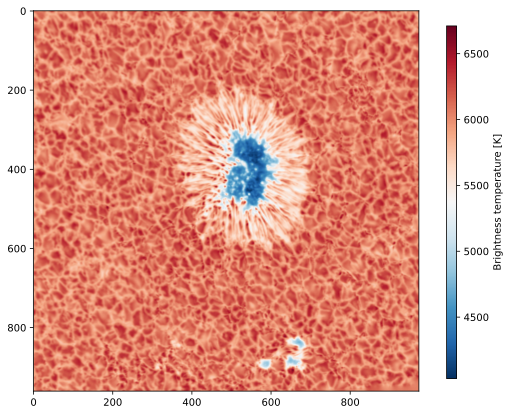

In [6]:
lam0 = 617.300 * units.nm   #rest wavelength

def T_b():
    """ Calculate brightness temperature """
    T_brightness = 1 / (np.log((2*h*((c/lam[0])**3))/(c**2 * intensity[0])/units.sr + 1) * (k_B / (h*(c/lam[0]))))
    return T_brightness.to("K")

fig, ax = plt.subplots(figsize=(7,7))
im1 = ax.imshow(T_b().value, cmap='RdBu_r');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)

cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Brightness temperature [K]",size=10)

In the plot presented above, visualizing the brightness temperature, we observe that the temperature of the whole sunspot (including the umbra and the surrounded penumbra) is lower than the brightness temperature of the granulation. We also observe that the brightness temperature in the umbra is lower than in the penumbra. The temperature of the pores in the bottom right corner, is also lower than the temperature in the granulation, though they are not as low as the umbra's temperature. 


Next, we want to calculate the velocity in order to interpret how the matter is moving in relation to us.  We need to take the shiftning of the velocity that occurs due to the Doppler effect into account, represened by the general formula

\begin{align}
\frac{ \lambda_0 - \lambda}{\lambda_0} = \frac{\Delta \lambda}{\lambda_0} = \frac{v}{c}.
\end{align}

where $\lambda = \lambda_{\text{shifted}}$ which is the Doppler shiftet wavelength, and $v$ is the velocity of the body. This formula is useful, since spectral lines also gets Doppler shiftet, so by finding the shiftet wavelength from the shiftet spectral line and by use of the Doppler shift equation, we can determine the velocity, which in our case will be the velocty along the line of sight, $v = v_{\text{los}}$. By use of this definition, a negative velocty indicates that the body is moving away from us, which is called red-shift, and a positive velocity indicates that the body is moving towards us, called blue-shift. 

The actual velocticy which we want to find is is given by

\begin{align}
v = \frac{v_{\text{los}}}{\text{cos}\theta},
\end{align}

where $v_{\text{los}}$ is the velocity found by use of Eq.(1), $\theta$ is the angle between line of sight and the normal of the emitting surface. So first we need to find the angle $\theta$, and this can be done by use of simple geometry.

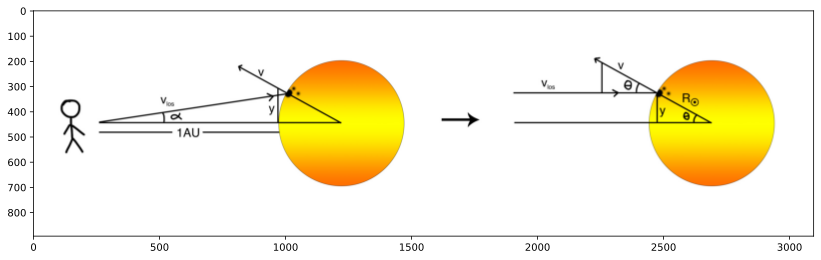

In [7]:
from PIL import Image
sunspot_earth = Image.open("figur_theta.jpg")
fig, ax = plt.subplots(figsize=(14,14))
im_scale = ax.imshow(sunspot_earth);

The centre of the image is (x, y) = (-473", 248") in Helioprojective cartesian coordinates, and the center of the solar disk is at (0, 0), and we assume that we are so far away that the line of sight to the sunspot and the position vector between the Sun and the Earth are entering parallel, and that the height $y$ is approximately the same in the illustration to the left and right. We can then find the angle $\alpha$, the height $y$, and then angle $\theta$. We get that

\begin{align}
\alpha = \sqrt{(248")^2 + (473")^2},
\end{align}

and by use of small angle approximation we get that $y$ is

\begin{align}
y = AU \alpha.
\end{align}

And since we say that the height $y$ in the triangle to the left in the figure is approximately the same as $y$ in the triangle to the right, and we get that

\begin{align}
\theta = \text{arcsin} \Big( \frac{y}{\text{R}_{\odot}} \Big),
\end{align}

and then we simply get cos$\theta$ by taking the cosine of the answer above.

In [24]:
alpha = np.sqrt((248**2) + (473**2)) / (3600*360)*2*np.pi
y = constants.au * alpha
theta = np.arcsin(y/constants.R_sun)
cos_theta = np.cos(theta)

The next thing we need to find is the Doppler shifted wavelength $\lambda_{\text{shifted}}$, which is the wavelength where the spectral line has its peak, the velocity shift. This can be found by use of

\begin{align}
\lambda_{\text{shifted}} = \frac{\int \lambda I_{\lambda} d\lambda}{\int I_{\lambda} d\lambda},
\end{align}

where the intensities and weavelengths are read from the observational data. This calculation takes a few minutes, so in order to save time it is wise to run the calculation of $\lambda_{\text{shifted}}$ one time and save the results in a file, which can be loaded when later needed. After this is calculated we can calculate $v_{\text{los}}$ and then $v$ in km/s, and then create a plot of the velocity of the body in order to observe where the matter is moving away or towards us (red-shifted or blue-shifted velocity).

In [9]:
# Calcualte the shift of wavelength
def lam_shifted_calc(data):
    integral_1 = np.zeros(data["intensity"][0].shape)
    integral_2 = np.zeros(data["intensity"][0].shape)
    intensity = np.zeros(data["intensity"].shape)

    for i in range(len(data["intensity"])):
        intensity[i] = data["intensity"][0].value - data["intensity"][i].value

    for i in range(len(data["intensity"][0])):
        for j in range(len(data["intensity"][0][0])):
            integral_1[i, j] = integ.trapz(data["wavelength"].value * intensity[:, i, j], data["wavelength"].value)
            integral_2[i, j] = integ.trapz(intensity[:, i, j], data["wavelength"].value)
    lam_shifted = integral_1 / integral_2   #calculating the shift in wavelegth caused by velocity shift
    np.save("lam_shifted.npy", lam_shifted) #saving the values to a npy file for later use

#lam_shifted_calc(data)

In [10]:
lam_shifted_load = np.load("lam_shifted.npy")
lam_new =  lam_shifted_load * units.nm

# Line of sight velocity:
def v_los(lam0, lam_new): 
    v_lineofsight = c * ((lam0 - lam_new)/lam0)
    return v_lineofsight.to("km/s")

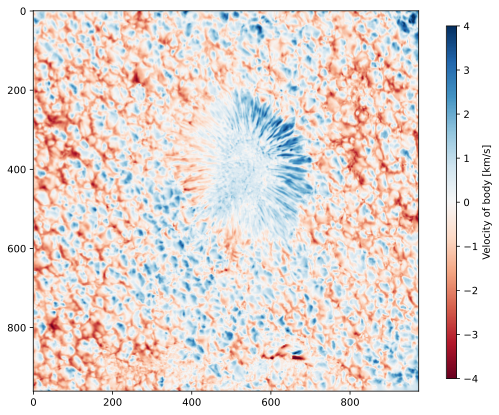

In [11]:
# Velocity:
def v(v_los,cos_theta): 
    velocity = v_los/cos_theta
    return velocity

fig, ax = plt.subplots(figsize=(7,7))
im_v = ax.imshow(v(v_los(lam0, lam_new),cos_theta), vmax=4, vmin=-4, cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_v, cax=cbar_ax)
cbar.set_label("Velocity of body [km/s]",size=10)
plt.show()

From the plot presented above, we observe that the matter in the sunspot is moving both toward and away from us. On the right side of the penumbra the velocity is blue-shifted, and the velocity on the right side is red-shifted, while the velocity in the umbra seems to be close to zero. We also observe that the velocity measured in granulation area on the upper right side to the penumbra is red-shifted, and that the velocity in the granulation area on the lower left side to the penumbra is blue-shifted. A possible explanation to this can be that matter is moving in a circular like shape up from the right side of the penumbra, over the umbra, and down again on the left side. Another possibility can be that matter is moving up from the right side of the penumbra and down again on the granulation area to the right, and same with the left side. We also observe that there are no remarkable velocities detected in the pores, but we observe two smaller areas between two of the pores where the velocities are higher, one tiny area moving towards us and another away from us. A possible reason for this might be that matter is moving from one pore to the other.

In addition, the estimation of $\lambda_{\text{shifted}}$ will have a corresponding variance $\sigma^2$. The variance can be given by the estimated value of the difference between the wavelength and $\lambda_{\text{shifted}}$ squared, scaled in the same way as we did with $\lambda_{\text{shifted}}$. This gives us a variance

\begin{equation}
\sigma^2 = \frac{\int (\lambda - \mu)^2 I_{\lambda} d \lambda}{\int I_{\lambda} d \lambda}
\end{equation}

which we can calculate by performing two integrals numerically.

In [23]:
# Calcualte the wavelength variance of a dataset

def sig_calc(data):    
    # Setting up empty temporary arrays for integration
    integral_3 = np.zeros(data["intensity"][0].shape)
    integral_4 = np.zeros(data["intensity"][0].shape)
    intensity = np.zeros(data["intensity"].shape)
    
    # Inverting the intensity to a Gaussian-like curve
    for i in range(len(data["intensity"])):
        intensity[i] = data["intensity"][0].value - data["intensity"][i].value
    
    # Looping through all pixels and calculating the integrals over wavelength
    for i in range(len(data["intensity"][0])):
        for j in range(len(data["intensity"][0][0])):
            integral_3[i, j] = integ.trapz( ((data["wavelength"].value - lam_shifted_load[i,j])**2)*intensity[:,i,j], data["wavelength"].value)
            integral_4[i, j] = integ.trapz(intensity[:, i, j], data["wavelength"].value)

    sigma2 = integral_3 / integral_4  #calculating the variance
    np.save("sigma2.npy", sigma2)     #saving the values to a npy file for later use

#sig_calc(data)

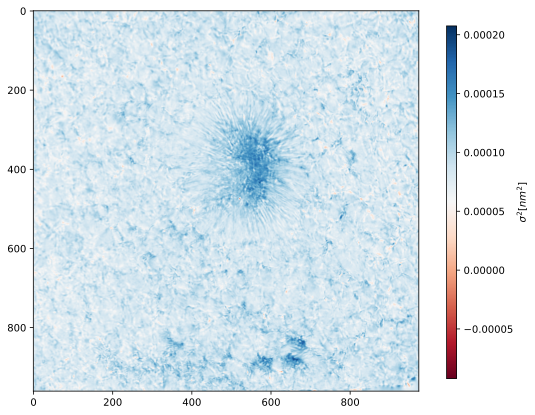

In [25]:
sigma2 = np.load("sigma2.npy") * units.nm

fig, ax = plt.subplots(figsize=(7,7))
im_sigma = ax.imshow(sigma2, cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_sigma, cax=cbar_ax)
cbar.set_label("$\sigma^2 [nm^2]$",size=10)

We can see from this plot that the sunspot umbra has a larger variance than the general granulation area. We can also see that the pores have a larger variance of the spectral line than the granulation area, just like the umbra. It is also possible to make out the penumbra from a caracteristic line structure around the umbra, though this area seems to have approximatelly the same variance values as the granulation area.

The variance is used to estimate the broadening of the absorption line, at different points in the sun, which is a result of the Zeeman effect. The Zeeman effect is a splitting of a spectral line as a result of a magnetic field splitting the energy levels of an excited electron. Then there are two very simular excitations and photons, at a larger interval of wavelength then we otherwise would expect, are scattered. These two energy levels are so close to eachother that they will appear as a single spectral line, just wider than we would expect without this effect. From (Pereira, 2020) the two energy levels will be splitt in the wavelength range by an interval

\begin{equation}
\lambda_{B} = \frac{e \lambda_0 B}{4 \pi m_e c},
\end{equation}

which is propotional to the magnetic field. By combining this result with the circular polarisation of light, Stokes V, and assuming that the Weak Field Approximation is true, it is possible to show that the observed magnetic flux density can be given by a

\begin{equation}
B_{los} = \frac{4 \pi m_e c}{e \bar{g} \lambda_0^2} \frac{\sum_{\lambda} \frac{\partial I}{\partial \lambda} V_{\lambda}}{\sum_{\lambda} \left( \frac{\partial I}{\partial \lambda} \right)^{2}},
\end{equation}

where $V_{\lambda}$ is Stokes V and $\bar{g}$ is the effective Landé factor.

In [22]:
# Calcualte the magnetic B-field of a dataset

def B_calc(data):
    # Empty temporary array for the derivative
    dI_dl = np.zeros(data["intensity"].shape)
    
    # Loop all pixels and calculate their derivative
    for i in range(len(data["intensity"][0])):
        for j in range(len(data["intensity"][0][0])):
            dI_dl[:, i, j] = np.gradient(data["intensity"][:, i, j], data["wavelength"])
    
    # Calculate the B-field
    B = - 4*np.pi*m_e*c / (e.si*g_*lam0**2)*np.sum(dI_dl*data["stokes_v"], axis=0) / np.sum(dI_dl**2, axis=0)
    np.save("B.npy", B.value) #saving the values to a npy file for later use

#B_calc(data)

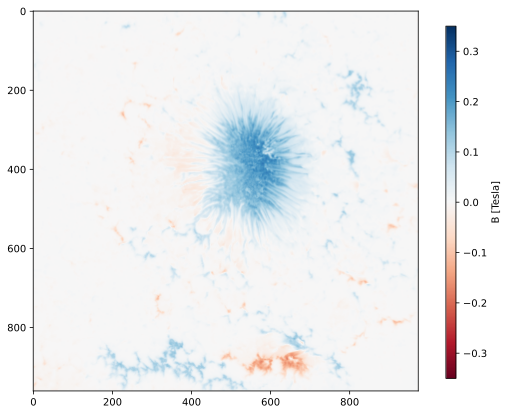

In [27]:
B = np.load("B.npy") * units.Unit("kg m / (s nm C)") #load B-filed values, find the actual value and apply units

fig, ax = plt.subplots(figsize=(7,7))
im_B = ax.imshow(B.to("Tesla"), vmin = -0.35, vmax=0.35, cmap = "RdBu");
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_B, cax=cbar_ax)
cbar.set_label("B [Tesla]",size=10)


Here we can see that the magnetic field is not dependant of the granulations, and that there is almost no magnetic field in this area. There are a few spots, but they look like they might be randomly placed. The sunspot however has a strong magnetic field with the direction of the field out of the surface of the Sun. We can also see that the pores are magentic, but only one of them has direction away from the surface, and two have into the surface. From this we might think that the magnetic field of the pores are connected, since we know that a magnetic field line needs a north and a south pole, and that the fields here goes from one pore to the other. If this is true, and as we have seen earlier, many of the properties of the pores are equal to the sunspot, we might be lead to think that also the spots come in pairs or groups with opposite magentic field. This is however not something we can conclude on from these data, since we don't have more than one sunspot. We also observe a magnetic field directed out of the surface in the granultion area to the left of the pores, which might have a connection to the pores, but since we want to focus mainly on the sunspot we choose not to look too much into that. 

If we look at the spectral line plot we produced earlier, we can see that the broadning of the spectral line coincides with where the magnetic field is stronger, as we expect, since the Zeeman effect would be larger here.

We would expect the magnetic field plot and the variance plot to be very simular, at least if we look at the absolute value of the magnetic field. We can "blink" the two plots, or the absolute value of the $B-$field and the variance, and get a better idea of how similare they are.

In [16]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
p = ax.imshow(np.abs(B.to("Tesla").value), vmin=-0.35, cmap = "RdBu")
q = ax.imshow(sigma2.value, cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())


At first glance the two images don't look that similar since the general structure of the variance plot is littered with fluctuations, while the magnetic field plot is much more uniform. However, the large scale structures are still very similar. We can see that where the magnetic field is strong, there is generally an increase in the variance just as we would expect. What we have not been able to guess earlier is that the pores in the magnetic field plot each have a hole. These three holes have no magnetic field, but a very large variance. Maybe the highest values of the variance in the whole dataset. If given more time, it would be interesting to look more into this later, plotting the spectral line of each of these points to check the form of the absorption curve. It would also be interesting to take more measurements from these points later, to study other broadening effects.

In [17]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
p = ax.imshow(T_b().value, cmap = "RdBu_r")
q = ax.imshow(v(v_los(lam0, lam_new),cos_theta).value,  vmax=4, vmin=-4,cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

Diskuterer og drøfter og sammenligner det vi ser. Grunner til hvorfor ting er sånn.. osv